In [171]:
from msc_project.experiments.fault_tolerant_boolean_circuits.fault_tolerant_logic_gates import robust_xor, maj_n
from circuits.neurons.operations import xor, bitwise
from circuits.neurons.core import Bit, gate, Neuron, step, BitFn
from circuits.tensors.mlp import Bits
import matplotlib.pyplot as plt
from msc_project.utils.circuit_visualiser import CircuitVisualiser
from circuits.sparse.compile import compiled_from_io, compiled
from msc_project.experiments.fault_tolerant_boolean_circuits.perturbable_stepmlp import PerturbableStepMLP
import numpy as np
import torch
import copy
from msc_project.experiments.fault_tolerant_boolean_circuits.monitor import Monitor
import pandas as pd
import seaborn as sns
import math
from collections.abc import Callable
import matplotlib as mpl

In [157]:
base = "/scratch/local/ssd/bella/msc-project/results/experiment_noise_tolerance/error_trace"

In [58]:
def noisy_xor(x : list[Bit], std: float) -> Bit:
    counter_weights = 1 + np.random.normal(loc=0.0, scale=std, size=(len(x), len(x)))
    bias_noise = np.random.normal(loc=0.0, scale=std, size=(len(x)))
    counters = [gate(x, weights, i + 1 + n) for i, weights, n in zip(range(len(x)), counter_weights, bias_noise)]
    final_noise = np.random.normal(loc=0.0, scale=std, size=(len(x)))
    final_bias_noise = np.random.normal(loc=0.0, scale=std, size=1)
    return gate(counters, [((-1) ** i) + noise for i, noise in zip(range(len(x)), final_noise)], 1 + final_bias_noise[0])

In [59]:
def gate(incoming: list[Bit], weights: list[float], threshold: float) -> Bit:
    """Create a linear threshold gate as a boolean neuron with a step function"""
    return Neuron(tuple(incoming), tuple(weights), -threshold, step).outgoing

def not_(x: Bit, std: float) -> Bit:
    weight : float = torch.randn(1).item() * std
    bias : float = torch.randn(1).item() * std
    return gate([x], [-1 + weight], bias)


def or_(x: list[Bit], std: float) -> Bit:
    weights = 1 + torch.randn(len(x)) * std
    bias = 1 + torch.randn(1).item() * std
    return gate(x, weights.tolist(), bias)


def and_(x: list[Bit], std: float) -> Bit:
    weights = 1 + torch.randn(len(x)) * std
    bias = len(x) + torch.randn(1).item() * std
    return gate(x, weights.tolist(), bias)

In [60]:
def noisy_robust_xor(x: list[Bit], std: float) -> Bit:
    
    def robust_xor2(a: Bit, b: Bit) -> Bit:
        a_or_b = or_([a, b], std)
        a_and_b = and_([a, b], std)
        not_a_and_b = not_(a_and_b, std)
        return and_([a_or_b, not_a_and_b], std)

    result = x[0]
    for bit in x[1:]:
        result = robust_xor2(result, bit)
    return result

In [61]:
def noisy_maj_n(x: list[Bit], std: float) -> Bit:
    weights = 1 + torch.randn(len(x)) * std
    bias = (math.ceil(len(x) / 2)) + torch.randn(1).item() * std
    return gate(x, weights.tolist(), bias)

In [162]:
def noisy_amp(x: Bit, std: float, amp_rate: int) -> list[Bit]:
    weights = (1 + torch.randn(amp_rate) * std).tolist()
    biases = (1 + torch.randn(amp_rate) * std).tolist()
    copies = [gate([x], [weights[i]], biases[i]) for i in range(amp_rate)]

    return copies

def amp(x: Bit, amp_rate: int) -> list[Bit]:
    copies = [gate([x], [1], 1) for _ in range(amp_rate)]
    return copies

In [163]:
def noisy_amps(x: list[Bit], std, amp_rate: int) -> list[list[Bit]]:
    copies = [noisy_amp(x_i, std, amp_rate) for x_i in x]
    copies = np.array(copies).T.tolist()
    return copies

def amps(x: list[Bit], amp_rate: int) -> list[list[Bit]]:
    copies = [amp(x_i, amp_rate) for x_i in x]
    copies = np.array(copies).T.tolist()
    return copies

In [64]:
copies = noisy_amps(Bits.from_str("1001").bitlist, 0.0, 3)

In [160]:
def noisy_maj_xor(x: list[Bit], std: float, redundancy: int, xor_fn: Callable[[list[Bit], float], Bit]) -> Bit:
    ambivalents = [xor_fn(x, std) for _ in range(redundancy)]
    return noisy_maj_n(ambivalents, std)

def get_noisy_maj_xor(redundancy: int, xor_fn) -> Callable[[list[Bit], float], Bit]:

    def xor(x: list[Bit], std: float) -> Bit:
        return noisy_maj_xor(x, std, redundancy, xor_fn)
    
    return xor

def get_maj_xor_bitfn(redundancy: int, xor_fn) -> BitFn:

    def xor(x: list[Bit]) -> list[Bit]:
        ambivalents = [xor_fn(x) for _ in range(redundancy)]
        return [maj_n(ambivalents)]
    
    return xor

In [164]:
def noisy_amp_maj_xor(x: list[Bit], std: float, redundancy: int, xor_fn: Callable[[list[Bit], float], Bit]) -> Bit:
    x_amp = noisy_amps(x, std, redundancy)
    ambivalents = [xor_fn(x_i, std) for x_i in x_amp]
    return noisy_maj_n(ambivalents, std)

def get_noisy_amp_maj_xor(redundancy: int, xor_fn) -> Callable[[list[Bit], float], Bit]:

    def xor(x: list[Bit], std: float) -> Bit:
        return noisy_amp_maj_xor(x, std, redundancy, xor_fn)
    
    return xor

def get_amp_maj_xor_bitfn(redundancy: int, xor_fn) -> BitFn:

    def xor(x: list[Bit]) -> list[Bit]:
        copies = amps(x, redundancy)
        ambivalents = [xor_fn(x_i) for x_i in copies]
        return [maj_n(ambivalents)]
    
    return xor

In [67]:
def get_noisy_xor_fn(std: float) -> BitFn:

    def xor(x:list[Bit]) -> list[Bit]:
        return [noisy_xor(x, std)]
    
    return xor

def get_noisy_robust_xor_fn(std: float) -> BitFn:

    def xor(x:list[Bit]) -> list[Bit]:
        return [noisy_robust_xor(x, std)]
    
    return xor

In [68]:
noise_stds = np.linspace(0.0010, 1.0, 100)

In [69]:
def get_gate_success_rates(xor_fn, input, expected_output, stds, num_samples) -> list[float]:

    np.random.seed(95)
    success_rates = []

    for std in stds:
        num_sucesses = 0
        for _ in range(num_samples):
            actual_output = xor_fn(input, std)

            num_sucesses += (actual_output.activation == expected_output)

        success_rates.append(num_sucesses / num_samples)

    return success_rates

In [70]:
def get_graph_success_rates(get_xor_fn, input, expected_output, stds, num_samples) -> list[float]:

    np.random.seed(95)
    success_rates = []

    for std in stds:
        num_sucesses = 0
        for _ in range(num_samples):
            xor_fn = get_xor_fn(std)
            graph = compiled(xor_fn, len(input))
            actual_output = graph.run(input)

            num_sucesses += (actual_output[0].activation == expected_output)

        success_rates.append(num_sucesses / num_samples)

    return success_rates

In [71]:
def get_success_rates(xor_fn, input, stds, num_samples):

    np.random.seed(95)
    success_rates = []
    models = []
    activations = []

    graph = compiled(xor_fn, len(input))
    mlp = PerturbableStepMLP.from_graph(graph)
    monitor = Monitor()
    monitor.register_hooks(mlp)
    expected_output = copy.deepcopy(mlp.infer_bits(input))

    activations.append(monitor.to_dataframe(std = 0.0))
    monitor.clear_data()
    
    for std in stds:
        num_sucesses = 0
        curr_models = []
        for _ in range(num_samples):
            mlp.perturb(std)
            curr_models.append(copy.deepcopy(mlp))
            actual_output = mlp.infer_bits(input)

            num_sucesses += (actual_output.bitstr == expected_output.bitstr)
            mlp.reset()
        models.append(curr_models)
        activations.append(monitor.to_dataframe(std=std))
        monitor.clear_data()
        success_rates.append(num_sucesses / num_samples)

    return success_rates, models, activations


In [72]:
def xor_fn(x: list[Bit]) -> list[Bit]:
    return [xor(x)]

def robust_xor_fn(x: list[Bit]) -> list[Bit]:
    return [robust_xor(x)]

In [73]:
success_rates_xor_gate = get_gate_success_rates(noisy_xor, Bits.from_str("1001").bitlist, 0, noise_stds, 100)

In [177]:
input_bits = Bits.from_str("1001")
input = input_bits.bitlist
output = Bits.from_str("0")

In [75]:
success_rates_robust_xor_gate = get_gate_success_rates(noisy_robust_xor, Bits.from_str("1001").bitlist, 0, noise_stds, 100)

In [78]:
success_rates_maj_xor_gate = {}
success_rates_maj_robust_xor_gate = {}
success_rates_maj_xor_gate[1] = get_gate_success_rates(get_noisy_maj_xor(1, noisy_xor), input, 0, noise_stds, 100)
success_rates_maj_robust_xor_gate[1] = get_gate_success_rates(get_noisy_maj_xor(1, noisy_robust_xor), input, 0, noise_stds, 100)
success_rates_maj_xor_gate[3] = get_gate_success_rates(get_noisy_maj_xor(3, noisy_xor), input, 0, noise_stds, 100)
success_rates_maj_robust_xor_gate[3] = get_gate_success_rates(get_noisy_maj_xor(3, noisy_robust_xor), input, 0, noise_stds, 100)
success_rates_maj_xor_gate[5] = get_gate_success_rates(get_noisy_maj_xor(5, noisy_xor), input, 0, noise_stds, 100)
success_rates_maj_robust_xor_gate[5] = get_gate_success_rates(get_noisy_maj_xor(5, noisy_robust_xor), input, 0, noise_stds, 100)
success_rates_maj_xor_gate[7] = get_gate_success_rates(get_noisy_maj_xor(7, noisy_xor), input, 0, noise_stds, 100)
success_rates_maj_robust_xor_gate[7] = get_gate_success_rates(get_noisy_maj_xor(7, noisy_robust_xor), input, 0, noise_stds, 100)

success_rates_amp_maj_xor_gate = {}
success_rates_amp_maj_robust_xor_gate = {}
success_rates_amp_maj_xor_gate[1] = get_gate_success_rates(get_noisy_amp_maj_xor(1, noisy_xor), input, 0, noise_stds, 100)
success_rates_amp_maj_robust_xor_gate[1] = get_gate_success_rates(get_noisy_amp_maj_xor(1, noisy_robust_xor), input, 0, noise_stds, 100)
success_rates_amp_maj_xor_gate[3] = get_gate_success_rates(get_noisy_amp_maj_xor(3, noisy_xor), input, 0, noise_stds, 100)
success_rates_amp_maj_robust_xor_gate[3] = get_gate_success_rates(get_noisy_amp_maj_xor(3, noisy_robust_xor), input, 0, noise_stds, 100)
success_rates_amp_maj_xor_gate[5] = get_gate_success_rates(get_noisy_amp_maj_xor(5, noisy_xor), input, 0, noise_stds, 100)
success_rates_amp_maj_robust_xor_gate[5] = get_gate_success_rates(get_noisy_amp_maj_xor(5, noisy_robust_xor), input, 0, noise_stds, 100)
success_rates_amp_maj_xor_gate[7] = get_gate_success_rates(get_noisy_amp_maj_xor(7, noisy_xor), input, 0, noise_stds, 100)
success_rates_amp_maj_robust_xor_gate[7] = get_gate_success_rates(get_noisy_amp_maj_xor(7, noisy_robust_xor), input, 0, noise_stds, 100)

In [197]:
noise_stds = np.linspace(0.0010, 1.0, 20)
xor_fns = [xor, robust_xor]
xor_fns_names = ["Baseline XOR", "Robust XOR"]
maj_fns = [get_maj_xor_bitfn]
maj_fns_names = ["Majority"]
voters = [1, 3, 5, 7]
success_rates_mlp = {}
models_mlp = {}
activations_mlp = {}

for xor_fn, xor_fn_name in zip(xor_fns, xor_fns_names):
    for maj_fn, maj_fn_name in zip(maj_fns, maj_fns_names):
        key = f"{xor_fn_name}"
        tmp_success_rates = {}
        tmp_models = {}
        tmp_activations = {}
        for num_voters in voters:
            partial_xor_fn = maj_fn(num_voters, xor_fn)
            tmp_success_rates[num_voters], tmp_models[num_voters], acts = get_success_rates(partial_xor_fn, input_bits, noise_stds, 100)
            tmp_activations[num_voters] = pd.concat(acts)

        success_rates_mlp[key] = tmp_success_rates
        models_mlp[key] = tmp_models
        activations_mlp[key] = tmp_activations


In [198]:
success_rates_mlp_df = pd.DataFrame(success_rates_mlp)
activations_mlp_df = pd.DataFrame(activations_mlp)

In [181]:
success_rates_mlp_df

,Baseline XOR Majority,Baseline XOR Majority + AMP,Robust XOR Majority,Robust XOR Majority + AMP
1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 0.99..."
3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 0.94, 0.9...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98, 0.92, 0.8..."
5,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99,...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.97, 0.98, 0.81, 0....","[1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 0.88, 0.72, 0...."
7,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 0.96, 0.9...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 0.97, 0.9...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.97, 0.9, 0.82, 0.5...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.71, 0.55, 0...."


In [79]:
success_rates_xor_graph = get_graph_success_rates(get_noisy_xor_fn, Bits.from_str("1001").bitlist, 0, noise_stds, 100)
success_rates_robust_xor_graph = get_graph_success_rates(get_noisy_robust_xor_fn, Bits.from_str("1001").bitlist, 0, noise_stds, 100)

In [85]:
cmap = mpl.colormaps['plasma']
colours = cmap(np.linspace(0,0.9,4))
linestyles = ["-", "--", "-.", ":"]

In [88]:
success_rates_gates = {
    "Baseline XOR": success_rates_maj_xor_gate,
    "Robust XOR": success_rates_maj_robust_xor_gate,
    "Baseline XOR + AMP": success_rates_amp_maj_xor_gate,
    "Robust XOR + AMP": success_rates_amp_maj_robust_xor_gate
}

success_rates_df = pd.DataFrame(success_rates_gates)

In [97]:
success_rates_df.columns[0]

'Baseline XOR'

In [155]:
def plot_success_rates(success_rates_df: pd.DataFrame, noise_stds: list[float], cmap_name : str = "plasma"):
        
    voters = success_rates_df.index.tolist()
    models = success_rates_df.columns
    fig, axes = plt.subplots(len(voters), 1, figsize=(15, 3*len(voters)))

    cmap = mpl.colormaps[cmap_name]
    colours = cmap(np.linspace(0,0.9,len(voters)))

    for ax, num_voters in zip(axes, voters):
        data = success_rates_df.loc[num_voters]
        for i, model in enumerate(models):
            model_data = data[model]
            ax.plot(noise_stds, model_data, color = colours[i], label=model)
        
        ax.set_ylabel("Success Rate (%)", fontsize='large')
        ax.set_xlabel("Standard Deviation", fontsize='large')
        ax.annotate(f"Number of voters: {num_voters}", xy=(-0.3, 0.5), xycoords=ax.transAxes, fontsize='x-large')
        ax.tick_params(labelsize='medium')
    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncols=len(models), bbox_to_anchor=(0.6, 1.04), fontsize='large')
    fig.tight_layout()
    return fig
    

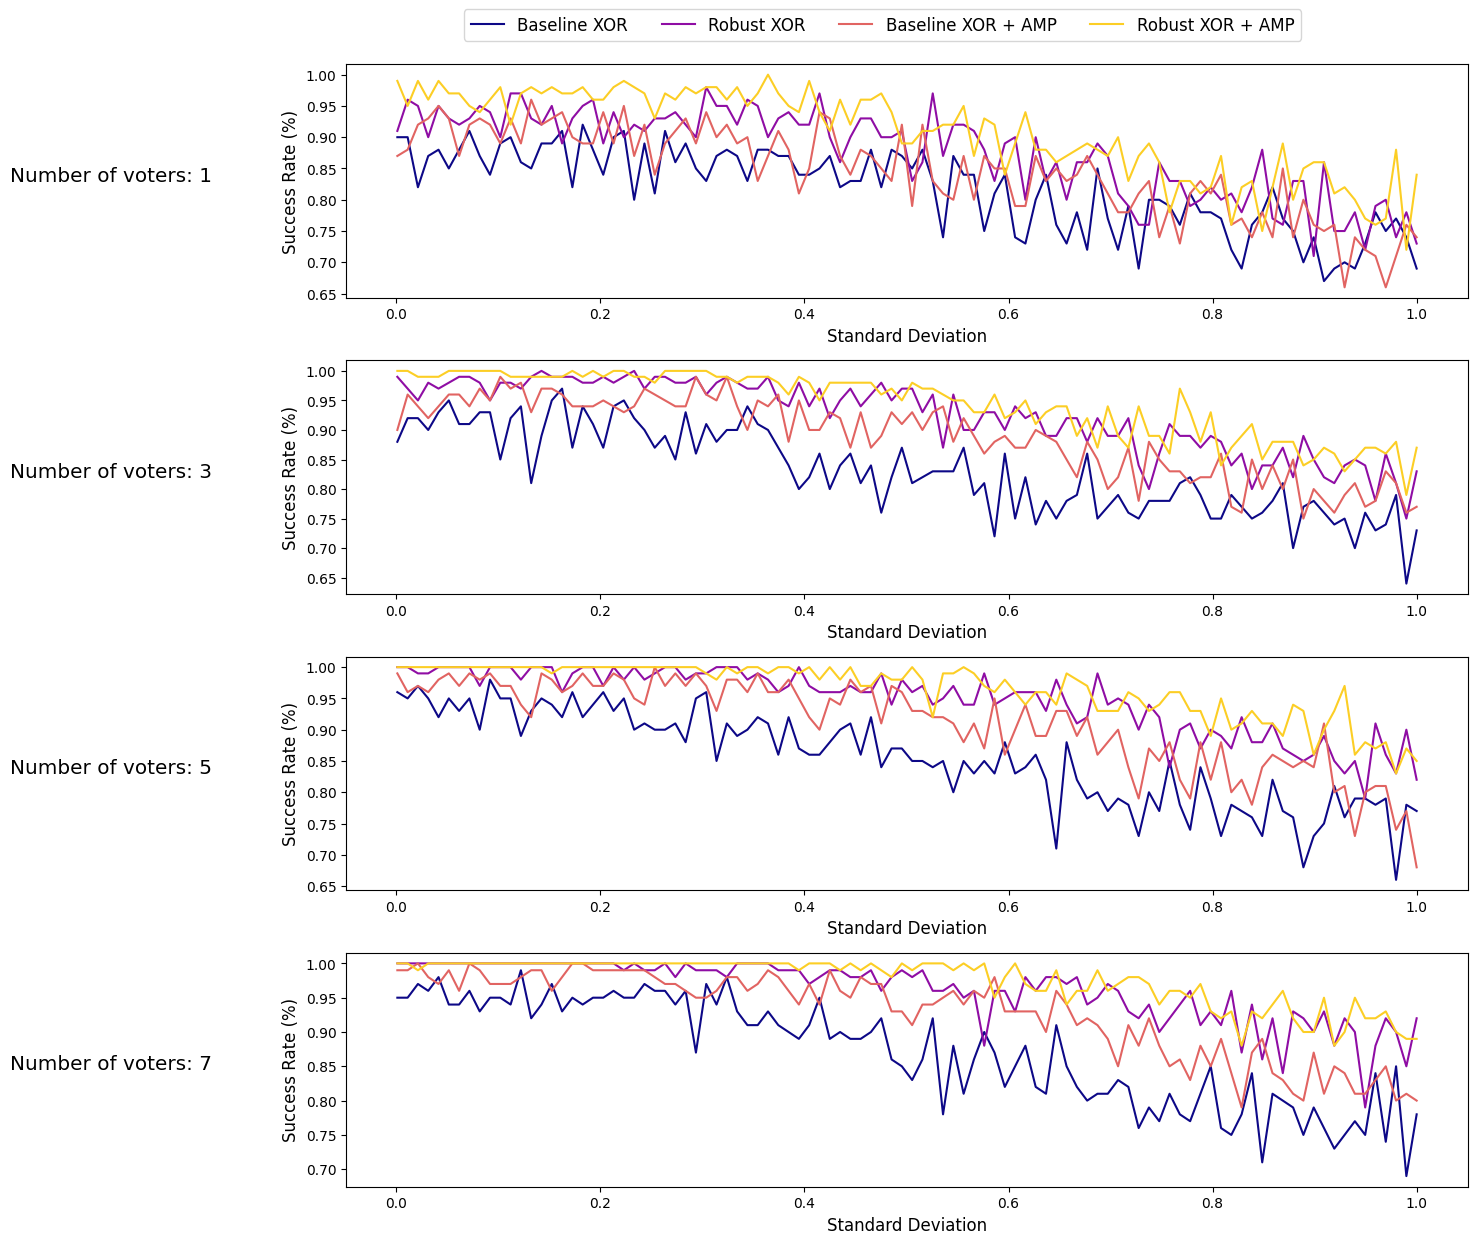

In [ ]:
f = plot_success_rates(success_rates_df, noise_stds.tolist())

In [184]:
success_rates_mlp_df_reduces = success_rates_mlp_df.drop(columns=["Baseline XOR Majority + AMP", "Robust XOR Majority + AMP"])

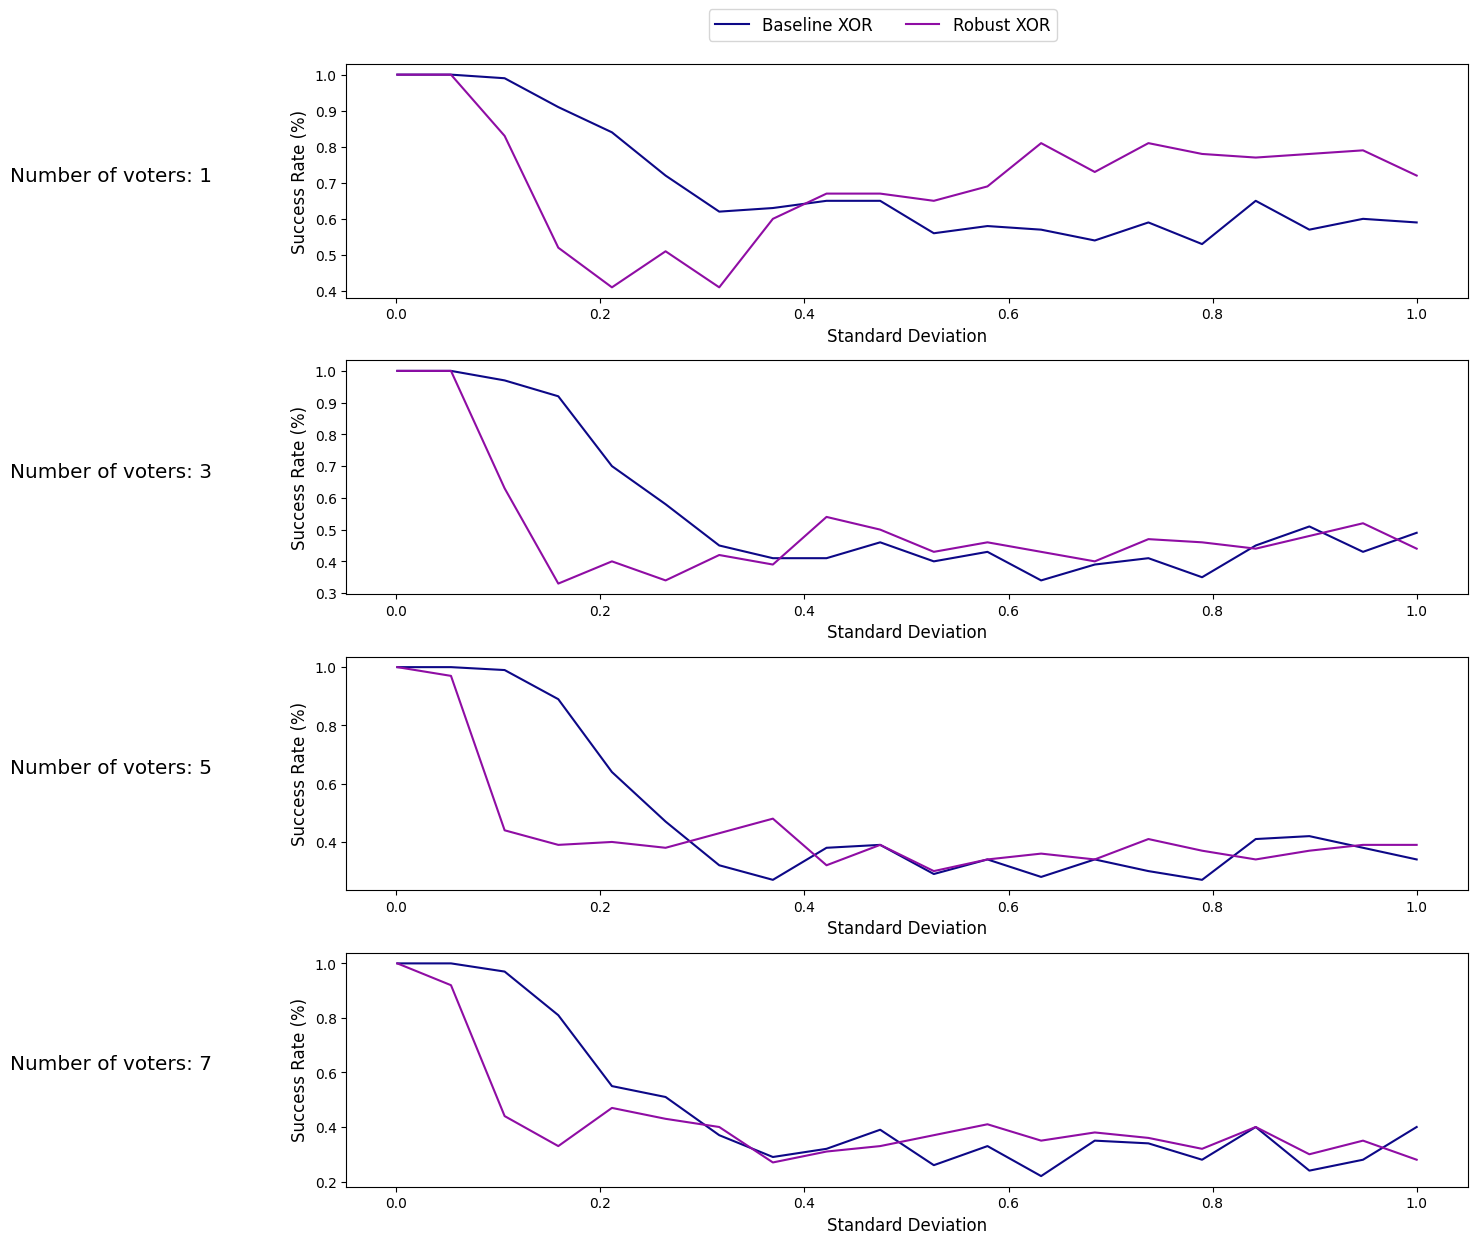

In [188]:
f = plot_success_rates(success_rates_mlp_df, noise_stds.tolist())
f.savefig(f"{base}/mlp_success_rate_per_num_voters_20_stds.pdf", bbox_inches="tight")

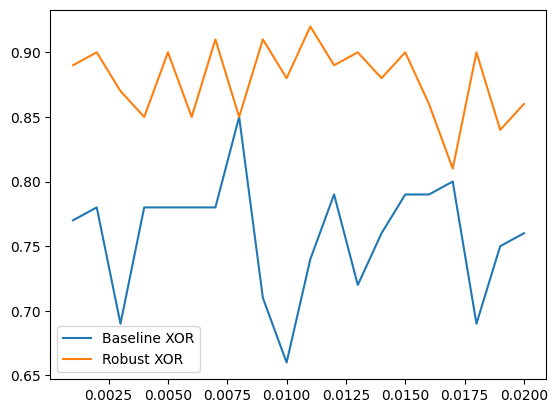

In [ ]:
plt.plot(noise_stds, success_rates_xor_graph, label="Baseline XOR")
plt.plot(noise_stds, success_rates_robust_xor_graph, label="Robust XOR")
plt.legend()

In [118]:
success_rate_xor_mlp, xor_mlps, xor_activations = get_success_rates(xor_fn, Bits.from_str("101"), noise_stds, 100)
success_rate_robust_xor_mlp, robust_xor_mlps, robust_xor_activations = get_success_rates(robust_xor_fn, Bits.from_str("101"), noise_stds, 100)

In [119]:
xor_df = pd.concat(xor_activations)
robust_xor_df = pd.concat(robust_xor_activations)

In [189]:
def compute_activation_diffs(df: pd.DataFrame) -> pd.DataFrame:
    
    def calc_diff_from_baseline(group):
        """For each group (model,layer_idx), compute differences from baseline."""
        
        # Find baseline row
        baseline = group[group['std'] == 0.0]
        
        if len(baseline) == 0:
            return pd.DataFrame()  # No baseline for this group
        
        baseline = baseline.iloc[0]
        baseline_pre = baseline['pre_activations']
        baseline_post = baseline['post_activations']
        
        # Compute differences for all noisy rows
        noisy = group[group['std'] > 0.0].copy()
        
        noisy['pre_diff'] = noisy['pre_activations'].apply(lambda x: np.abs(x - baseline_pre))
        noisy['post_diff'] = noisy['post_activations'].apply(lambda x: np.abs(x - baseline_post))
        
        # Add summary statistics
        noisy['pre_mae'] = noisy['pre_diff'].apply(np.mean)
        noisy['post_ber'] = noisy['post_diff'].apply(np.mean)
        
        return noisy
    
    result = df.groupby(['layer_idx'], group_keys=False).apply(calc_diff_from_baseline)
    
    return result.reset_index(drop=True)

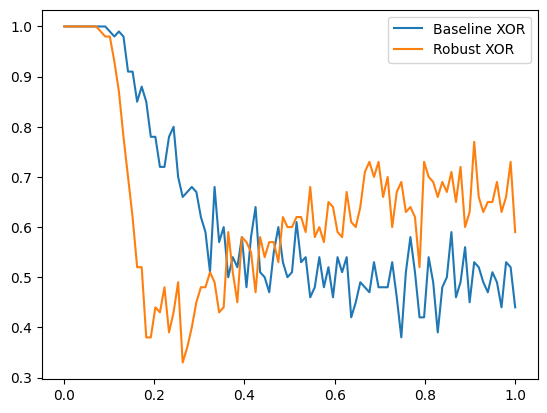

In [121]:
plt.plot(noise_stds, success_rate_xor_mlp, label="Baseline XOR")
plt.plot(noise_stds, success_rate_robust_xor_mlp, label="Robust XOR")
plt.legend()

In [202]:
activations_mlp_df["Baseline XOR"].index

Index([1, 3, 5, 7], dtype='int64')

In [205]:
activation_errors = {}
mean_activation_errors = {}
for key, sub_dict in activations_mlp.items():
    tmp = {}
    tmp_mean = {}
    for sub_key, df in sub_dict.items():
        tmp[sub_key] = compute_activation_diffs(df)
        tmp_mean[sub_key] = tmp[sub_key].groupby(["layer_idx", "std"])[["pre_mae", "post_ber"]].mean()
    activation_errors[key] = tmp
    mean_activation_errors[key] = tmp_mean

/tmp/ipykernel_200476/2446897302.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['layer_idx'], group_keys=False).apply(calc_diff_from_baseline)
/tmp/ipykernel_200476/2446897302.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['layer_idx'], group_keys=False).apply(calc_diff_from_baseline)
/tmp/ipykernel_200476/2446897302.py:28: FutureWarning: DataFrameGroupBy.apply op

In [122]:
xor_errors = compute_activation_diffs(xor_df)
robust_xor_errors = compute_activation_diffs(robust_xor_df)

/tmp/ipykernel_32323/2446897302.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['layer_idx'], group_keys=False).apply(calc_diff_from_baseline)
/tmp/ipykernel_32323/2446897302.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['layer_idx'], group_keys=False).apply(calc_diff_from_baseline)


In [123]:
xor_error_means = xor_errors.groupby(["layer_idx", "std"])[["pre_mae", "post_ber"]].mean()
robust_xor_error_means = robust_xor_errors.groupby(["layer_idx", "std"])[["pre_mae", "post_ber"]].mean()

In [124]:
robust_xor_error_means.to_csv()

'layer_idx,std,pre_mae,post_ber\n0,0.001,0.0013489781178073518,0.0\n0,0.011090909090909092,0.015522957134437671,0.0\n0,0.021181818181818184,0.0309122492367907,0.0\n0,0.03127272727272727,0.04254288315478821,0.0\n0,0.041363636363636366,0.05866356919361776,0.0\n0,0.05145454545454546,0.06743226636125932,0.0\n0,0.06154545454545455,0.09005657619253128,0.0\n0,0.07163636363636364,0.09833121703395882,0.0\n0,0.08172727272727273,0.1137096516262873,0.0\n0,0.09181818181818183,0.1190726830669794,0.0\n0,0.10190909090909092,0.14354243505354422,0.0\n0,0.112,0.15439831180861938,0.005\n0,0.1220909090909091,0.17052503820493783,0.0175\n0,0.13218181818181818,0.17317143653689906,0.0125\n0,0.14227272727272727,0.19241799778649277,0.025\n0,0.15236363636363637,0.2113659402865666,0.03\n0,0.16245454545454546,0.233048837516451,0.0375\n0,0.17254545454545456,0.2377556691231435,0.0575\n0,0.18263636363636365,0.2700919471441211,0.08\n0,0.19272727272727275,0.26466803982296616,0.065\n0,0.20281818181818184,0.27388856535292

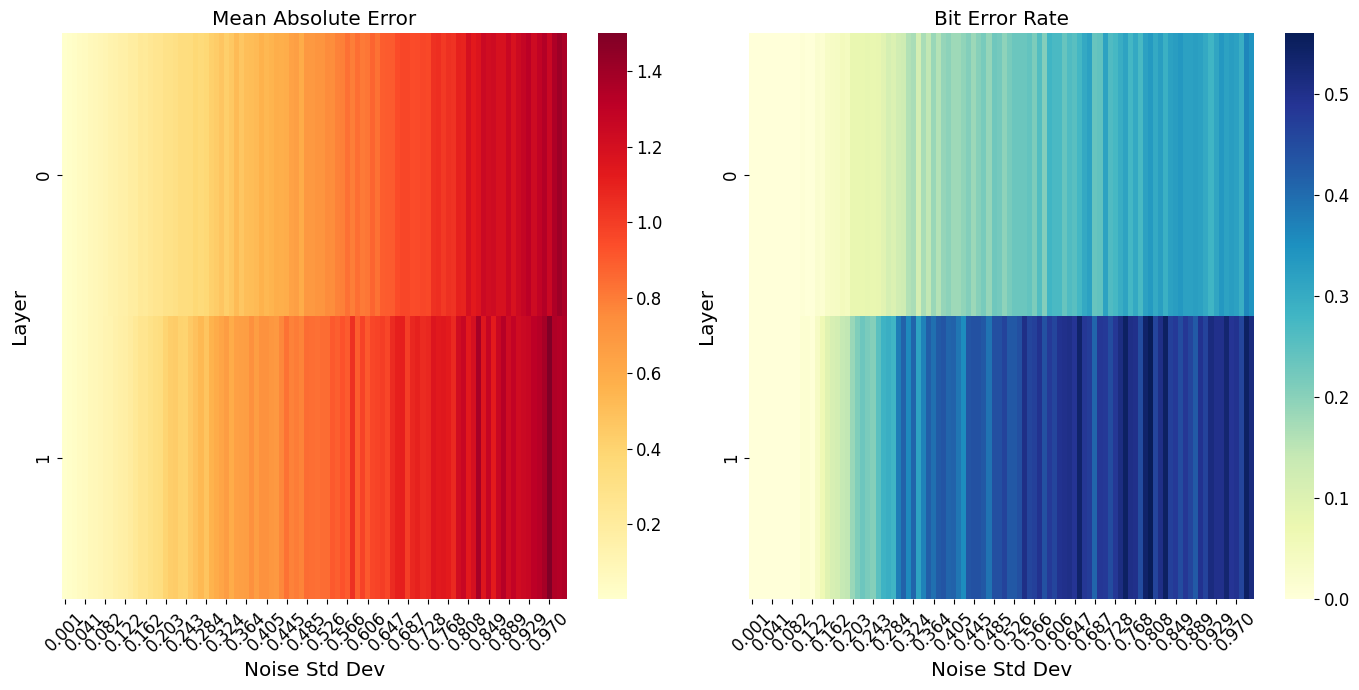

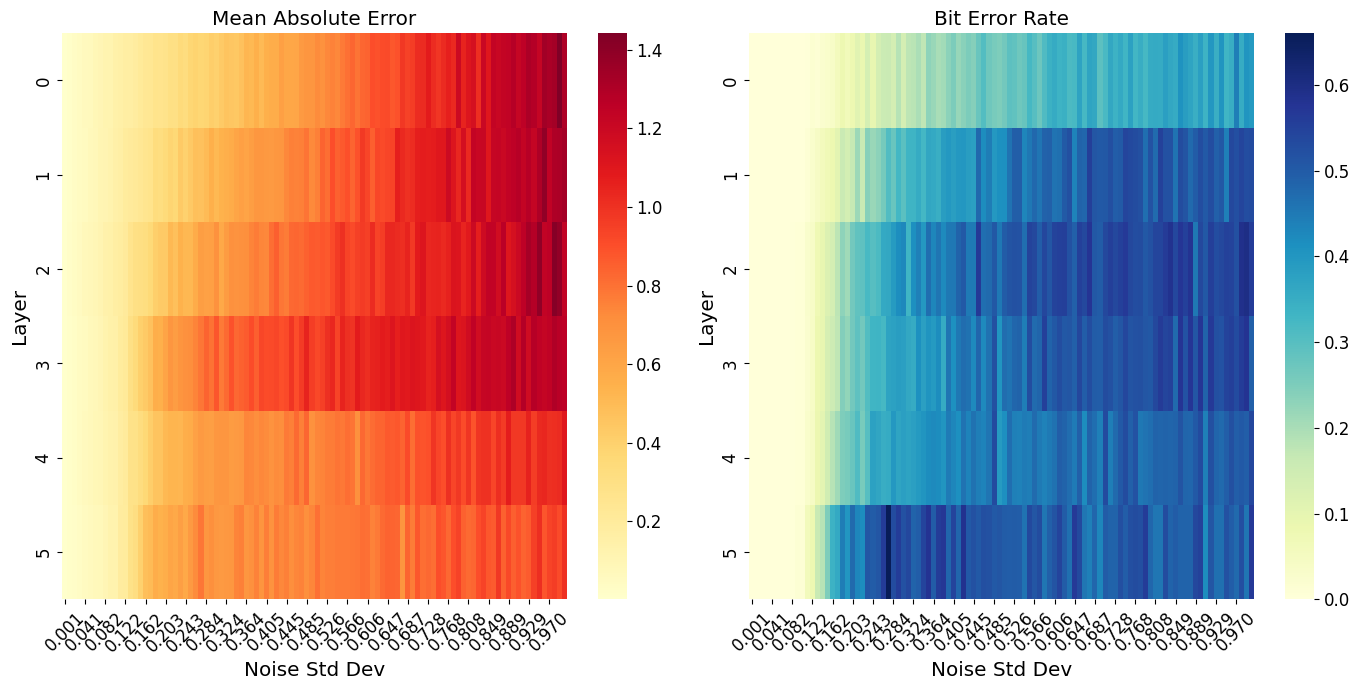

In [125]:
for model_data in [xor_error_means, robust_xor_error_means]:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))


    mae_pivot = model_data['pre_mae'].unstack('std')
    ber_pivot = model_data['post_ber'].unstack('std')
    mae_pivot.columns = [f'{col:.3f}' for col in mae_pivot.columns]
    ber_pivot.columns = [f'{col:.3f}' for col in ber_pivot.columns]
    
    # MAE heatmap
    sns.heatmap(mae_pivot, ax=ax1, cmap='YlOrRd')
    cbar1 = ax1.collections[0].colorbar
    cbar1.ax.tick_params(labelsize='large')
    ax1.set_title(f'Mean Absolute Error', fontdict={'fontsize': 'x-large'})
    ax1.set_xlabel('Noise Std Dev', fontdict={'fontsize': 'x-large'})
    ax1.set_ylabel('Layer', fontdict={'fontsize': 'x-large'})
    ax1.tick_params(axis='x', labelrotation=45)
    
    ax1.tick_params(axis='both', labelsize='large')
    
    # BER heatmap
    sns.heatmap(ber_pivot, ax=ax2, cmap='YlGnBu')
    cbar2 = ax2.collections[0].colorbar
    cbar2.ax.tick_params(labelsize='large')
    ax2.set_title(f'Bit Error Rate', fontdict={'fontsize': 'x-large'})
    ax2.set_xlabel('Noise Std Dev', fontdict={'fontsize': 'x-large'})
    ax2.set_ylabel('Layer', fontdict={'fontsize': 'x-large'})
    ax2.tick_params(axis='x', labelrotation=45)
    
    ax2.tick_params(axis='both', labelsize='large')
    
    plt.tight_layout()

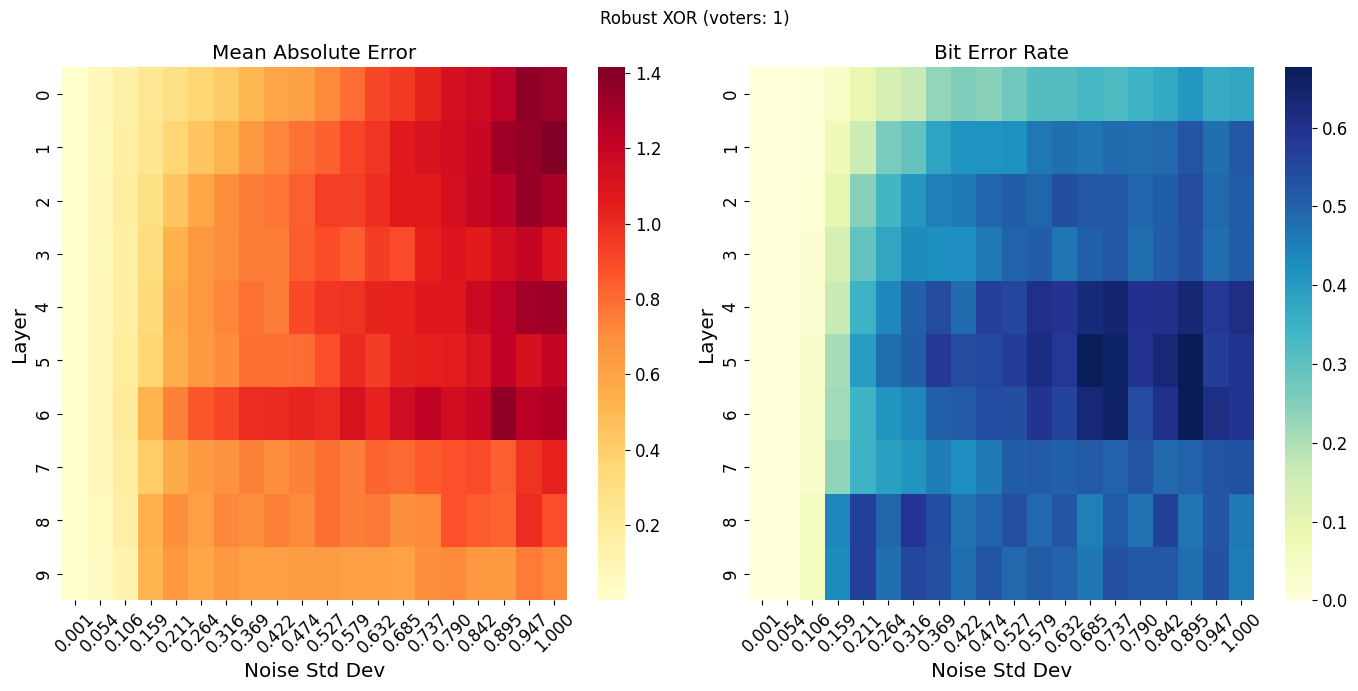

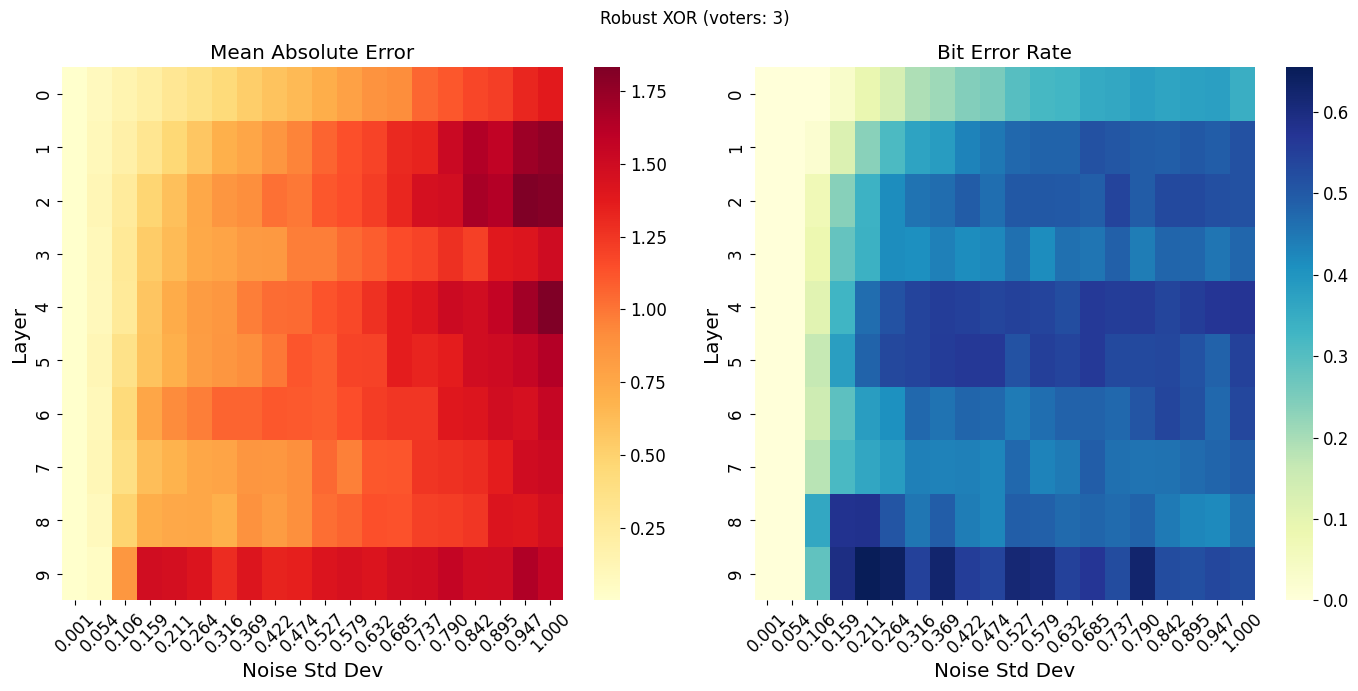

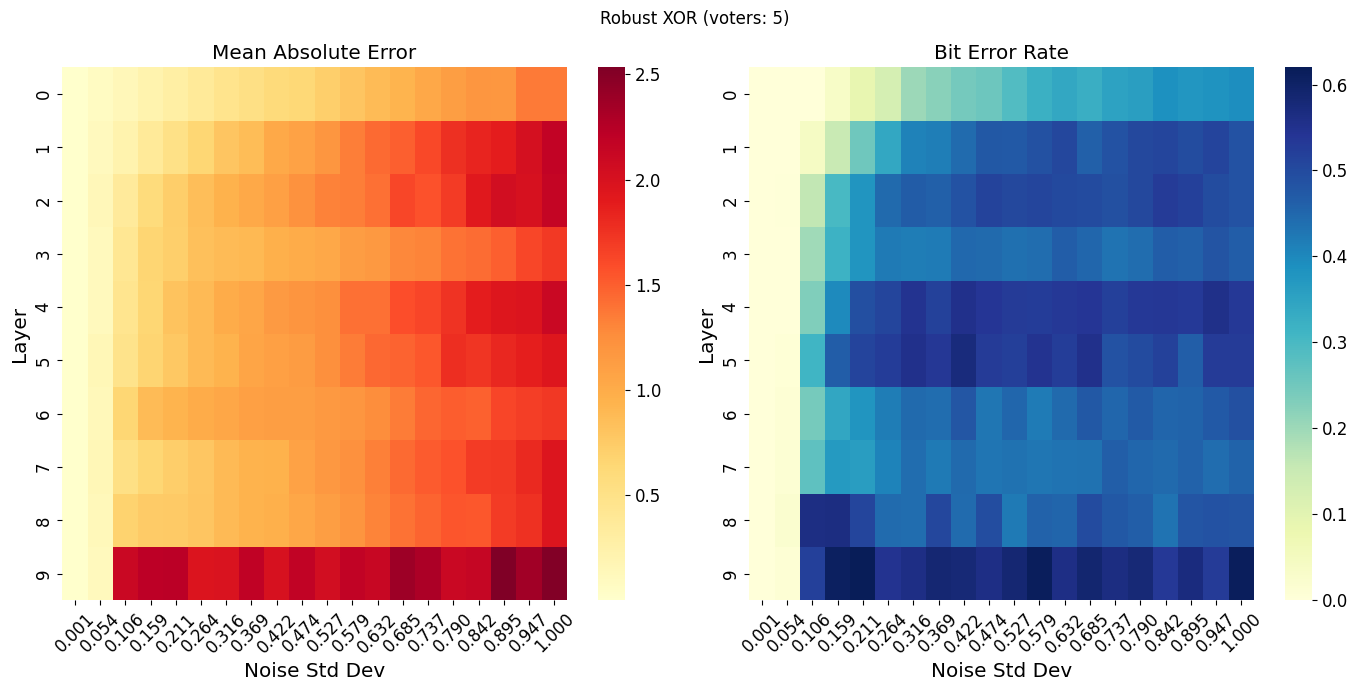

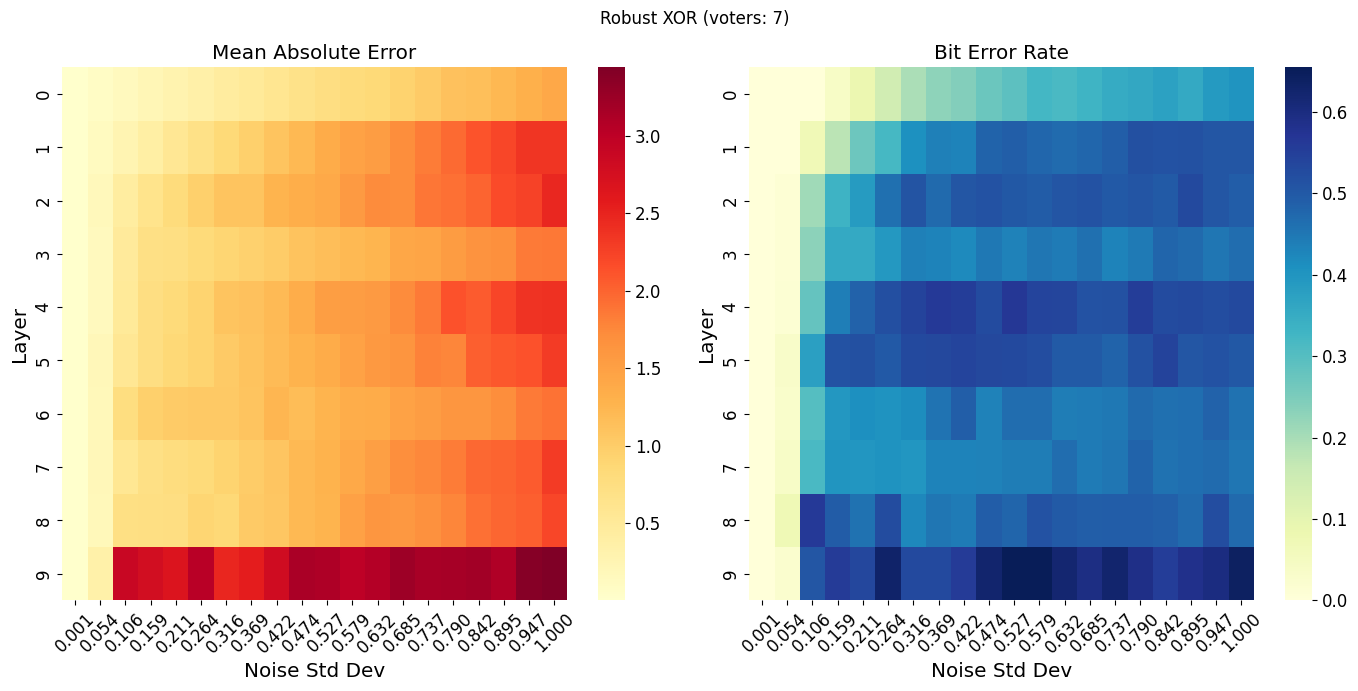

In [209]:
for num_voters, model_data in mean_activation_errors["Robust XOR"].items():
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))


    mae_pivot = model_data['pre_mae'].unstack('std')
    ber_pivot = model_data['post_ber'].unstack('std')
    mae_pivot.columns = [f'{col:.3f}' for col in mae_pivot.columns]
    ber_pivot.columns = [f'{col:.3f}' for col in ber_pivot.columns]
    
    # MAE heatmap
    sns.heatmap(mae_pivot, ax=ax1, cmap='YlOrRd')
    cbar1 = ax1.collections[0].colorbar
    cbar1.ax.tick_params(labelsize='large')
    ax1.set_title(f'Mean Absolute Error', fontdict={'fontsize': 'x-large'})
    ax1.set_xlabel('Noise Std Dev', fontdict={'fontsize': 'x-large'})
    ax1.set_ylabel('Layer', fontdict={'fontsize': 'x-large'})
    ax1.tick_params(axis='x', labelrotation=45)
    
    ax1.tick_params(axis='both', labelsize='large')
    
    # BER heatmap
    sns.heatmap(ber_pivot, ax=ax2, cmap='YlGnBu')
    cbar2 = ax2.collections[0].colorbar
    cbar2.ax.tick_params(labelsize='large')
    ax2.set_title(f'Bit Error Rate', fontdict={'fontsize': 'x-large'})
    ax2.set_xlabel('Noise Std Dev', fontdict={'fontsize': 'x-large'})
    ax2.set_ylabel('Layer', fontdict={'fontsize': 'x-large'})
    ax2.tick_params(axis='x', labelrotation=45)
    
    ax2.tick_params(axis='both', labelsize='large')
    fig.suptitle(f"Robust XOR (voters: {num_voters})")
    plt.tight_layout()
    fig.savefig(f"{base}/activation_errors_robust_xor_voters_{num_voters}.pdf", bbox_inches="tight")

In [136]:
visualiser = CircuitVisualiser()

In [137]:
noisy_xor_fn = get_noisy_xor_fn(0.8)
noisy_robust_xor_fn = get_noisy_robust_xor_fn(0.8)

In [138]:
input_str = "101"

Graph analysis complete:
  - Input nodes: 3
  - Output nodes: 1
  - Total nodes: 11
  - Constants: 0
  - Disconnected: False
Graph saved as robust_xor.pdf


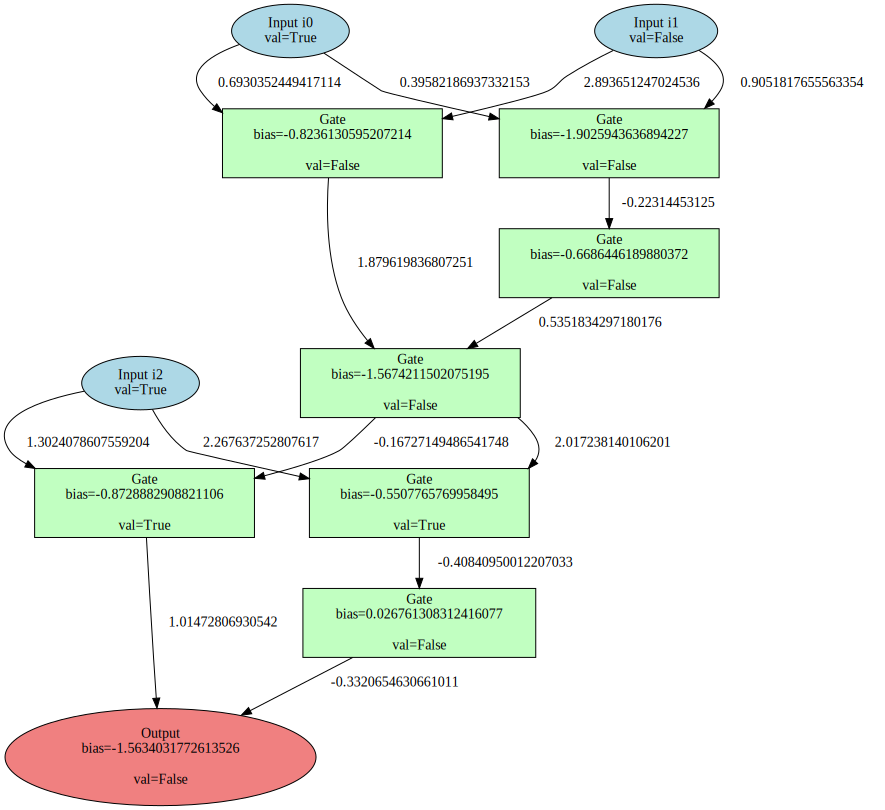

In [139]:
visualiser.visualise_method(noisy_robust_xor_fn, 3, "robust_xor", input_str)

Graph analysis complete:
  - Input nodes: 3
  - Output nodes: 1
  - Total nodes: 7
  - Constants: 0
  - Disconnected: False
Graph saved as baseline_xor.pdf


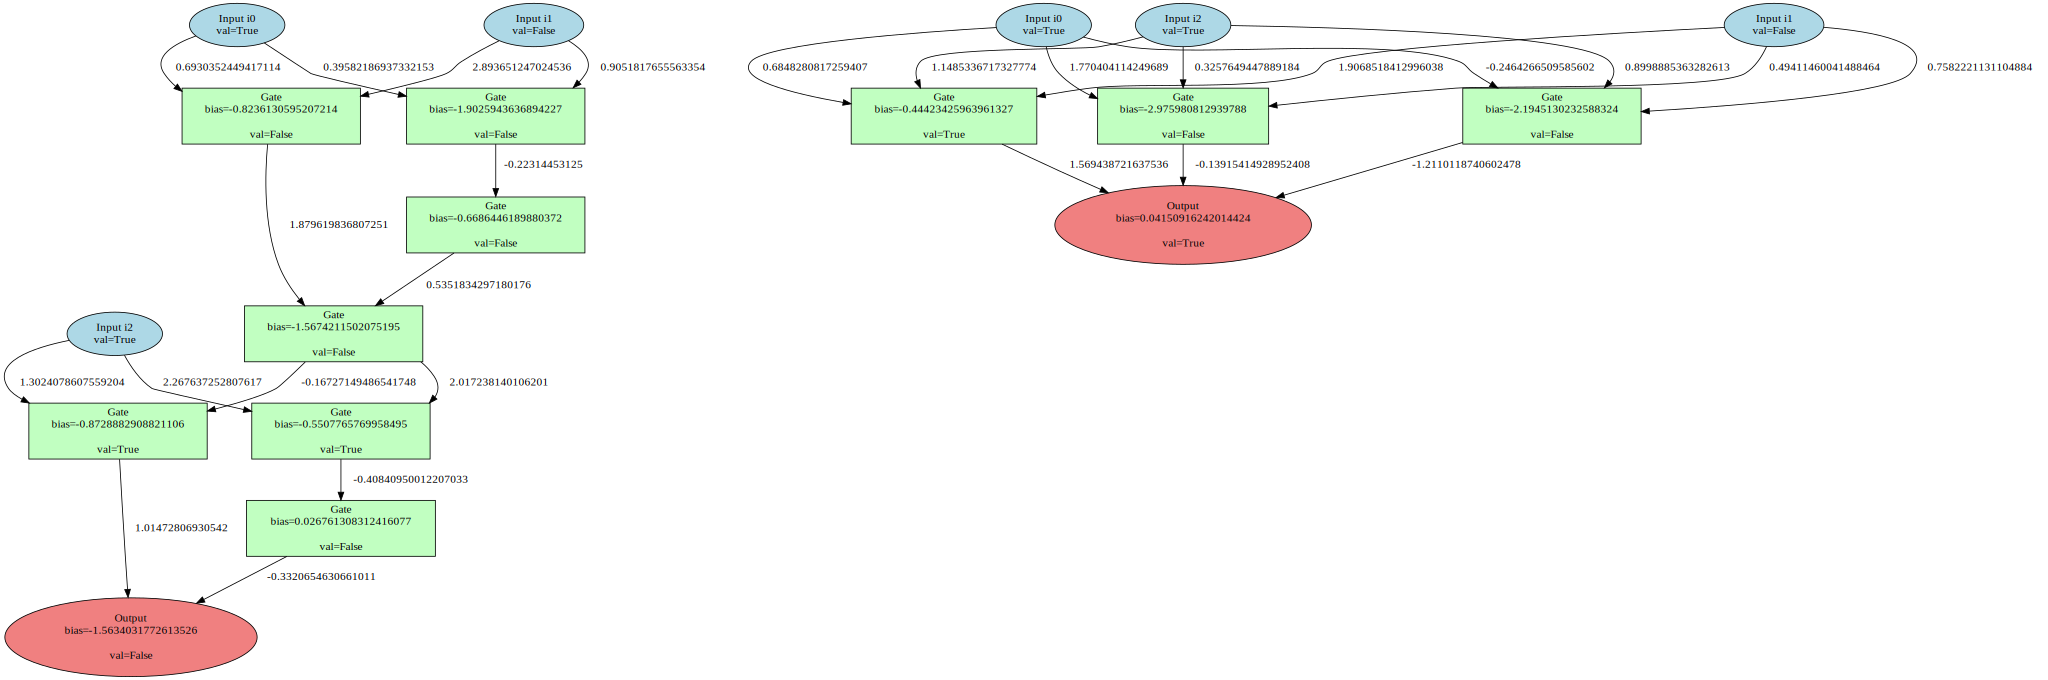

In [140]:
visualiser.visualise_method(noisy_xor_fn, 3, "baseline_xor", input_str)